In [4]:
import numpy
import monai

In [8]:
import glob
import nibabel as nib
import numpy as np
from os.path import isfile
import datetime
from IPython.display import clear_output

uncorr_files = glob.glob('/project/ajoshi_27/rodent_bfc_data4ML/data4ML/*uncorr.nii.gz')
print(uncorr_files)


for f in uncorr_files:
  sub_name = f[:-14]

  corr_file = sub_name + '_corr.nii.gz'
  uncorr_file = sub_name + '_uncorr.nii.gz'
  output_file = sub_name + '_bias.nii.gz'

  if isfile(output_file):
    continue

  print(sub_name)

  # Load the NIfTI images using nibabel
  image1 = nib.load(corr_file).get_fdata()
  image2 = nib.load(uncorr_file).get_fdata().squeeze()



  #when we augment, make sure that the log domain is correctly accounted for

  # Calculate the ratio of the two images
  ratio = np.divide(image2, image1, out=np.zeros_like(image2), where=image1 != 0)

  # Save the ratio as a NIfTI file
  ratio_image = nib.Nifti1Image(ratio, affine=nib.load(uncorr_file).affine)  # Assuming no affine transformation
  nib.save(ratio_image, output_file)

  print(f"Ratio image saved as {output_file}")


clear_output()


/home1/ajoshi/.local/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:396: RuntimeWarning: overflow encountered in scalar add
  vmean = .5 * (vmin + vmax)


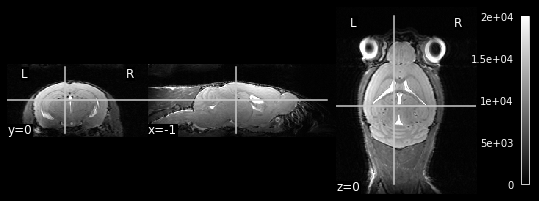

In [12]:
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

#from nilearn.plotting import plot_anat

nifti_file1 = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/1_BC_uncorr.nii.gz'
nifti_file2 = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/1_BC_corr.nii.gz'
nifti_file3 = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/1_BC_bias.nii.gz'

# Load the NIfTI file
#nifti_img = nib.load(nifti_file)

# Plot the image using nilearn
#plotting.view_img(nifti_file1, bg_img=False, cmap='gray', colorbar=True, symmetric_cmap=False)

plotting.plot_anat(nifti_file1, colorbar=True,vmax=2e4,vmin=0,black_bg='k')

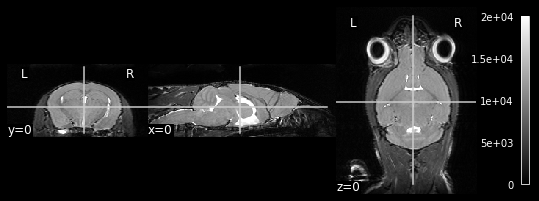

In [13]:
plotting.plot_anat(nifti_file2, colorbar=True, vmax=2e4,vmin=0)

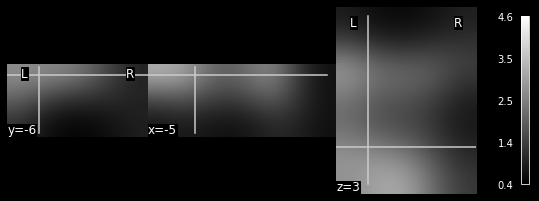

In [14]:
plotting.plot_anat(nifti_file3, colorbar=True)

In [22]:
import torch
import monai
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from torch.nn import MSELoss
from monai.data import Dataset, DataLoader, partition_dataset

from monai.transforms import Compose, LoadImaged, AddChanneld, SqueezeDim, SqueezeDimd, ToTensord,LoadImage,AddChannel,ToTensor,EnsureChannelFirstD,EnsureChannelFirst, Resize, RandBiasFieldd
from monai.utils import set_determinism
from glob import glob
import random

# Set random seed for reproducibility
set_determinism(seed=0)

# Define your dataset and data loader
class BiasFieldCorrectionDataset(Dataset):
    def __init__(self, image_files, bias_files, transform=None):
        self.image_files = image_files
        self.bias_files = bias_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self.transform(self.image_files[idx])
        bias = self.transform(self.bias_files[idx])
        return {'image': image, 'bias': bias}

# Assuming you have a list of paired image and bias file paths
#image_files = ['image1.nii.gz', 'image2.nii.gz']
#bias_files = ['bias_field1.nii.gz', 'bias_field2.nii.gz']

image_files = (glob('/project/ajoshi_27/rodent_bfc_data4ML/data4ML/*uncorr.nii.gz'))
bias_files = (glob('/project/ajoshi_27/rodent_bfc_data4ML/data4ML/*bias.nii.gz'))

# Define transformations
#transforms = Compose([LoadImaged(keys=['image', 'bias'],image_only=True), AddChanneld(keys=['image', 'bias']), ToTensord(keys=['image', 'bias'])])
#transforms = Compose([LoadImage(image_only=True), Resize(), EnsureChannelFirst(), ToTensor()])


data_dicts = [{"image": image, "bias": bias} for image, bias in zip(image_files, bias_files)]

random.seed(11)

#random.shuffle(data_dicts)
num_files = len(data_dicts)
num_train_files = round(0.8 * num_files)
train_files = data_dicts[:num_train_files]
val_files = data_dicts[num_train_files:]
print("total num files:", len(data_dicts))
print("num training files:", len(train_files))
print("num validation files:", len(val_files))



total num files: 28
num training files: 22
num validation files: 6


In [32]:
print(train_files)
print(val_files)

print('Val file dim')
for f in val_files:
    print(nib.load(f['image']).shape)
    print(nib.load(f['bias']).shape)

print('Training file dim')
for f in train_files:
    print(nib.load(f['image']).shape)
    print(nib.load(f['bias']).shape)


[{'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/4_LC_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/2_BC_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/6_BC_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/xtraF_LC_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/4_RC_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/5_BC_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/1_LCRP_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/4_RC_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/xtraF_BC_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/4_RCLP_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/5_LC_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/3_RC_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/1_RCLP_uncor

In [48]:

"""
# Define transformations, including resizing to
x64x64
transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
   # RandBiasField(prob=1, coeff_range=(0.2,0.3)),
    Resize(spatial_size=(64, 64, 64)),
    ToTensor(),
])
"""
from monai.transforms import Compose, Resized, LoadImaged, AddChanneld, EnsureChannelFirstd, RandAffined, ToTensord,LoadImage,AddChannel,ToTensor,EnsureChannelFirstD,EnsureChannelFirst, Resize, RandBiasFieldd
from monai.data import (
    CacheDataset,
    DataLoader,
    Dataset,
    pad_list_data_collate,
    TestTimeAugmentation,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


keys = ["image", "bias"]

train_transforms = Compose([
    LoadImaged(keys,image_only=True),
    EnsureChannelFirstd(keys),    
#    SqueezeDimd(keys=["image"],dim=3),
    RandAffined(
            keys,
            prob=1.0,
            rotate_range=0*(np.pi / 3, np.pi / 3, np.pi / 3),
            translate_range=0*(30,30,30),
            scale_range=0*(0.3,0.3,0.3),
            padding_mode=("zeros","reflection"),
#            mode=("trilinear", "trilinear"),
        ),
    Resized(
            keys,
            spatial_size=(64, 64, 64),
#            mode=("trilinear", "trilinear"),
    ),
    # RandBiasField(prob=1, coeff_range=(0.2,0.3)),
      #ToTensor(),
])


val_transforms = Compose([
    LoadImaged(keys,image_only=True),
    EnsureChannelFirstd(keys),    
#    SqueezeDimd(keys=["image"],dim=3),
    RandAffined(
            keys,
            prob=1.0,
            rotate_range=0*(np.pi / 3, np.pi / 3, np.pi / 3),
            translate_range=0*(30,30,30),
            scale_range=0*(0.3,0.3,0.3),
            padding_mode=("zeros","reflection"),
#            mode=("trilinear", "trilinear"),
        ),
    Resized(
            keys,
            spatial_size=(64, 64, 64),
#            mode=("trilinear", "trilinear"),
    ),

   # RandBiasField(prob=1, coeff_range=(0.2,0.3)),
    #ToTensor(),
])



train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=4, num_workers=10, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10, collate_fn=pad_list_data_collate)



# Create dataset and data loader
#dataset = BiasFieldCorrectionDataset(image_files, bias_files, transform=transforms)


# Split the dataset into training and validation sets


# Create data loaders for training and validation
#train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define the UNet model and optimizer

# Specify spatial_dims and strides for 3D data
spatial_dims = 3
strides = (1, 1, 1, 1)

model = UNet(
    spatial_dims=spatial_dims,
    in_channels=1,  # Adjust based on your data
    out_channels=1, # Adjust based on your data
    channels=(2,8,8,16,32),#(16, 64, 64, 128, 256),
    strides=strides,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the Dice loss
loss_function = MSELoss() # DiceLoss(sigmoid=True)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for batch in train_loader:

        inputs, biases = batch['image'].to(device), torch.log(batch['bias']).to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, biases)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_train_loss / len(train_loader)}")


    # Validation loop
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            inputs, biases = batch['image'].to(device), torch.log(batch['bias']).to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, biases)
            total_val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {total_val_loss / len(val_loader)}")


current_datetime = datetime.datetime.now()

# Format the date and time as a string
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Create a filename with the formatted date and time
filename = f"/project/ajoshi_27/code_farm/rodbfc/models/bias_field_correction_model_{formatted_datetime}.pth"

# Save the trained model
torch.save(model.state_dict(), filename)



Loading dataset: 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]
/home1/ajoshi/.local/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home1/ajoshi/.local/lib/python3.9/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)
/home1/ajoshi/.local/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be remove

Epoch 1/100, Training Loss: 0.40976835787296295
Epoch 1/100, Validation Loss: 0.24174161503712335
Epoch 2/100, Training Loss: 0.2502089664340019
Epoch 2/100, Validation Loss: 0.21112359563509622
Epoch 3/100, Training Loss: 0.22460069507360458
Epoch 3/100, Validation Loss: 0.19017614920934042
Epoch 4/100, Training Loss: 0.20360114177068075
Epoch 4/100, Validation Loss: 0.16935215642054877
Epoch 5/100, Training Loss: 0.1890739326675733
Epoch 5/100, Validation Loss: 0.1562249263127645
Epoch 6/100, Training Loss: 0.1755186840891838
Epoch 6/100, Validation Loss: 0.14074284583330154
Epoch 7/100, Training Loss: 0.16605387876431146
Epoch 7/100, Validation Loss: 0.1291623351474603
Epoch 8/100, Training Loss: 0.15951205044984818
Epoch 8/100, Validation Loss: 0.1246262863278389
Epoch 9/100, Training Loss: 0.15183096627394357
Epoch 9/100, Validation Loss: 0.11701225737730662
Epoch 10/100, Training Loss: 0.14689131950338682
Epoch 10/100, Validation Loss: 0.11338801930348079
Epoch 11/100, Training L

(64, 64, 64)
(192, 256, 100)
torch.Size([192, 256, 100])


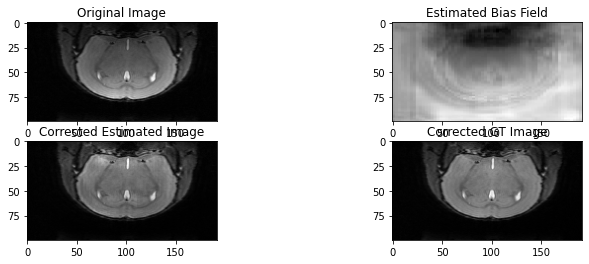

In [50]:
try:
  import monai
except:
  !pip install monai pytorch-gpu nilearn
  import monai

import numpy as np
import nibabel as nib
import torch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from torch.nn import MSELoss
from monai.data import Dataset, DataLoader, partition_dataset

from monai.transforms import Compose, LoadImaged, AddChanneld, ToTensord,LoadImage,AddChannel,ToTensor,EnsureChannelFirstD,EnsureChannelFirstd, Resized, Resize, RandBiasFieldd
from monai.utils import set_determinism
from glob import glob
import random
import matplotlib.pyplot as plt


# Define the UNet model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify spatial_dims and strides for 3D data
spatial_dims = 3
strides = (1, 1, 1, 1)

model = UNet(
    spatial_dims=spatial_dims,
    in_channels=1,  # Adjust based on your data
    out_channels=1, # Adjust based on your data
    channels=(2,8,8,16,32),#(16, 64, 64, 128, 256)/8,
    strides=strides,
).to(device)



keys=["image"]

test_transforms = Compose([
    LoadImaged(keys,image_only=True),
    EnsureChannelFirstd(keys),
    Resized(
            keys,
            spatial_size=(64, 64, 64),
        ),
   # RandBiasField(prob=1, coeff_range=(0.2,0.3)),
    #ToTensor(),
])

model.eval()

# Load the test image (adjust the path to your validation image)
test_image_path = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/3_RC_uncorr.nii.gz'
test_ground_truth_corrected_image_path = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/3_RC_corr.nii.gz'
test_corrected_image_path = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/3_RC_uncorr.bfc.nii.gz'
model_file='models/bias_field_correction_model_2023-09-17_01-14-26.pth'

model.load_state_dict(torch.load(model_file))


test_dict = [{"image":test_image_path}]
#test_dict = [{"image": image, "bias": bias} for image, bias in zip(image_files, bias_files)]
# Apply transformations to the validation image
test_image = test_transforms(test_dict)[0]["image"].to(device)

# Apply the trained model to estimate the bias field
with torch.no_grad():
    estimated_bias_field = model(test_image[None,])

# Convert the estimated bias field to a Numpy array
estimated_bias_field = estimated_bias_field.squeeze().cpu().numpy()

print(estimated_bias_field.shape)
# Load the original validation image without resizing (for displaying the corrected image)
original_test_image = nib.load(test_image_path).get_fdata().squeeze()
original_test_corrected_image = nib.load(test_ground_truth_corrected_image_path).get_fdata().squeeze()

orig_shape = original_test_image.shape

print(orig_shape)

estimated_bias_field_resized = Resize(spatial_size=orig_shape)(estimated_bias_field[None,])[0]

print(estimated_bias_field_resized.shape)
# Apply the estimated bias field to correct the original image
corrected_image = original_test_image / np.exp(estimated_bias_field_resized)

# Display the original image, estimated bias field, and corrected image
plt.figure(figsize=(12, 4))
plt.subplot(221)
plt.title("Original Image")
plt.imshow(original_test_image[:, original_test_image.shape[1] // 2, :].T, cmap='gray')

plt.subplot(222)
plt.title("Estimated Bias Field")
plt.imshow(estimated_bias_field_resized[:, estimated_bias_field_resized.shape[1] // 2, :].T, cmap='gray')

plt.subplot(223)
plt.title("Corrected Estimated Image")
plt.imshow(corrected_image[:, corrected_image.shape[1] // 2, :].T, cmap='gray')

plt.subplot(224)
plt.title("Corrected GT Image")
plt.imshow(original_test_corrected_image[:, original_test_image.shape[1] // 2, :].T, cmap='gray')



plt.show()

input_nifti = nib.load(test_image_path)
input_dtype = input_nifti.get_data_dtype()
corrected_image = corrected_image.astype(input_dtype)


# Create a new NIfTI image with the result data
result_nifti = nib.Nifti1Image(corrected_image, input_nifti.affine)

# Save the result as a new NIfTI image
nib.save(result_nifti, test_corrected_image_path)


